In [9]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
#Down nltk packages
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Variable to store all the comparision parameters
results = []
window_size = 2

## Task 1

##### Load Real World Data

Load Harry Potter Corpus
Source: https://github.com/ErikaJacobs/Harry-Potter-Text-Mining/tree/master

In [12]:
corpus = ''
for i in range(1,2):
    with open(f'corpus-dataset/HPBook{i}.txt', 'r', errors='ignore') as file:
        data = file.read()
        sents = data.split('\n')
        sents = sents[1:-1]
        text =  '\n'.join(sents)
        corpus+= ' '+text

In [13]:
#Sentence Tokenization
sents = nltk.sent_tokenize(corpus)

In [14]:
sents[2]

'Mr. Dursley was the director of a firm called Grunnings, which made drills.'

In [15]:
#Remove Punctuations from the corpus
import string
processed_sents = [sent.translate(str.maketrans('', '', string.punctuation)) for sent in sents]
#convert into lower case
processed_sents = [sent.lower() for sent in processed_sents]


In [16]:
processed_sents[2]

'mr dursley was the director of a firm called grunnings which made drills'

In [17]:
#1. Word tokenization
tokenized_corpus = [nltk.word_tokenize(sent) for sent in processed_sents]

In [18]:
#Remove stop words from corpus
stop_words = set(stopwords.words('english'))

tokenized_corpus = [[w for w in sent if not w.lower() in stop_words] for sent in tokenized_corpus]

In [19]:
tokenized_corpus

[['boy',
  'lived',
  'mr',
  'mrs',
  'dursley',
  'number',
  'four',
  'privet',
  'drive',
  'proud',
  'say',
  'perfectly',
  'normal',
  'thank',
  'much'],
 ['last',
  'people',
  'youd',
  'expect',
  'involved',
  'anything',
  'strange',
  'mysterious',
  'didnt',
  'hold',
  'nonsense'],
 ['mr',
  'dursley',
  'director',
  'firm',
  'called',
  'grunnings',
  'made',
  'drills'],
 ['big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache'],
 ['mrs',
  'dursley',
  'thin',
  'blonde',
  'nearly',
  'twice',
  'usual',
  'amount',
  'neck',
  'came',
  'useful',
  'spent',
  'much',
  'time',
  'craning',
  'garden',
  'fences',
  'spying',
  'neighbors'],
 ['dursleys',
  'small',
  'son',
  'called',
  'dudley',
  'opinion',
  'finer',
  'boy',
  'anywhere'],
 ['dursleys',
  'everything',
  'wanted',
  'also',
  'secret',
  'greatest',
  'fear',
  'somebody',
  'would',
  'discover'],
 ['didnt', 'think', 'could', 'bear', 'anyone', 'found', 'potters'],
 ['mrs'

In [20]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(tokenized_corpus))) #all the words we have in the system - <UNK>

In [21]:
vocabs

['africa',
 'anything',
 'head',
 'halfmoon',
 'expects',
 'shivering',
 'goblin',
 'parked',
 'destroyed',
 'glider',
 'pies',
 'hooch',
 'burns',
 'boarhound',
 'powdered',
 'strawberries',
 'cannonball',
 'dashing',
 'grudgingly',
 'hummed',
 'sleep',
 'terrified',
 'dusty',
 'stiffly',
 'brew',
 'earn',
 'vanished',
 'work',
 'pinkfaced',
 'breakin',
 'watch',
 'basket',
 'monk',
 'boxes',
 'lasted',
 'shiny',
 'towering',
 'reared',
 'halfway',
 'cows',
 'haircut',
 'judging',
 'innocent',
 'smaller',
 'finally',
 'best',
 'pewter',
 'november',
 'mumbled',
 'jars',
 'mixture',
 'speechless',
 'sneak',
 'wafting',
 'froze',
 'trained',
 'sets',
 'candies',
 'nonsense',
 'weave',
 'panic',
 'moaned',
 'creeps',
 'tricks',
 'angelina',
 'horror',
 'albus',
 'leaned',
 'coat',
 'mounted',
 'jokes',
 'reckon',
 'meself',
 'smiling',
 'hung',
 'monkshood',
 'changing',
 'threes',
 'diversion',
 'standing',
 'chessboard',
 'part',
 'blankets',
 'smelled',
 'hengist',
 'affect',
 'fainte

In [22]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['potter']

5001

In [23]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [24]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'shivering'

In [25]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(window_size, len(doc)-window_size):
            #center word
            center = word2index[doc[i]]
            #outside words = 4 words
            outside = (word2index[doc[i-2]], word2index[doc[i-1]], word2index[doc[i+1]], word2index[doc[i+2]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2 , center, outside2 center, outside4

    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)

    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])

    return np.array(inputs), np.array(labels)

x, y = random_batch(2, tokenized_corpus)

In [26]:
x.shape  #batch_size, 1

(2, 1)

In [27]:
x

array([[2459],
       [4709]])

In [28]:
y.shape  #batch_size 1

(2, 1)

In [29]:
len(vocabs)

5912

In [30]:
embedding = nn.Embedding(9340, 2)

In [31]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape  #(batch_size, 1, emb_size)

torch.Size([2, 1, 2])

### Wor2Vec(Skipgram) without Negative Sampling

In [32]:
class Skipgram(nn.Module):

    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)

        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)

        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)

        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar

        return loss


In [33]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[   0,    1,    2,  ..., 5909, 5910,    6],
        [   0,    1,    2,  ..., 5909, 5910,    6]])

In [34]:
model_1 = Skipgram(voc_size, 2)
model_1

Skipgram(
  (embedding_center): Embedding(5912, 2)
  (embedding_outside): Embedding(5912, 2)
)

In [35]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [36]:
loss = model_1(input_tensor, label_tensor, all_vocabs)

In [37]:
loss

tensor(11.6993, grad_fn=<NegBackward0>)

### Training Skipgram Without Negative Sampling

In [38]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model_1.parameters(), lr=0.001)

In [39]:
num_epochs = 10000

start_time = time.time()

for epoch in range(num_epochs):

    #get batch
    input_batch, label_batch = random_batch(batch_size, tokenized_corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)

    #predict
    loss = model_1(input_tensor, label_tensor, all_vocabs)

    #backproga
    optimizer.zero_grad()
    loss.backward()

    #update alpha
    optimizer.step()

    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")
end_time = time.time()
total_sg_without_neg_sample = end_time - start_time

sg_without_sampling_result = {"model_name":"Skipgram Without Negative Sampling", "window_size":window_size,  "training_loss": f"{loss:2.6f}", "training_time":total_sg_without_neg_sample/60}

Epoch   1000 | Loss: 8.620390
Epoch   2000 | Loss: 9.378458
Epoch   3000 | Loss: 8.715167
Epoch   4000 | Loss: 9.250184
Epoch   5000 | Loss: 9.635653
Epoch   6000 | Loss: 8.253755
Epoch   7000 | Loss: 8.473640
Epoch   8000 | Loss: 8.407386
Epoch   9000 | Loss: 8.662651
Epoch  10000 | Loss: 8.686974


In [40]:
sg_without_sampling_result

{'model_name': 'Skipgram Without Negative Sampling',
 'window_size': 2,
 'training_loss': '8.686974',
 'training_time': 25.110362935066224}

In [41]:
vocabs

['africa',
 'anything',
 'head',
 'halfmoon',
 'expects',
 'shivering',
 'goblin',
 'parked',
 'destroyed',
 'glider',
 'pies',
 'hooch',
 'burns',
 'boarhound',
 'powdered',
 'strawberries',
 'cannonball',
 'dashing',
 'grudgingly',
 'hummed',
 'sleep',
 'terrified',
 'dusty',
 'stiffly',
 'brew',
 'earn',
 'vanished',
 'work',
 'pinkfaced',
 'breakin',
 'watch',
 'basket',
 'monk',
 'boxes',
 'lasted',
 'shiny',
 'towering',
 'reared',
 'halfway',
 'cows',
 'haircut',
 'judging',
 'innocent',
 'smaller',
 'finally',
 'best',
 'pewter',
 'november',
 'mumbled',
 'jars',
 'mixture',
 'speechless',
 'sneak',
 'wafting',
 'froze',
 'trained',
 'sets',
 'candies',
 'nonsense',
 'weave',
 'panic',
 'moaned',
 'creeps',
 'tricks',
 'angelina',
 'horror',
 'albus',
 'leaned',
 'coat',
 'mounted',
 'jokes',
 'reckon',
 'meself',
 'smiling',
 'hung',
 'monkshood',
 'changing',
 'threes',
 'diversion',
 'standing',
 'chessboard',
 'part',
 'blankets',
 'smelled',
 'hengist',
 'affect',
 'fainte

In [42]:
potter = torch.LongTensor([word2index['potter']])
potter

tensor([5001])

In [43]:
potter_embed_c = model.embedding_center(potter)
potter_embed_o = model.embedding_outside(potter)
potter_embed   = (potter_embed_c + potter_embed_o) / 2
potter_embed

tensor([[ 0.5912, -1.0372]], grad_fn=<DivBackward0>)

In [44]:
potter_embed_o

tensor([[ 1.2589, -0.5581]], grad_fn=<EmbeddingBackward0>)

In [45]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']

    word = torch.LongTensor([word2index[word]])

    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2

    return embed[0][0].item(), embed[0][1].item()

In [46]:
get_embed('ron')

(-0.9255111217498779, -0.003774702548980713)

In [47]:
get_embed('hogwarts')

(1.067744255065918, 0.14414235949516296)

In [48]:
get_embed('harry')

(-0.4642706513404846, -0.789512038230896)

In [49]:
get_embed('potter')

(0.5911828279495239, -1.0371673107147217)

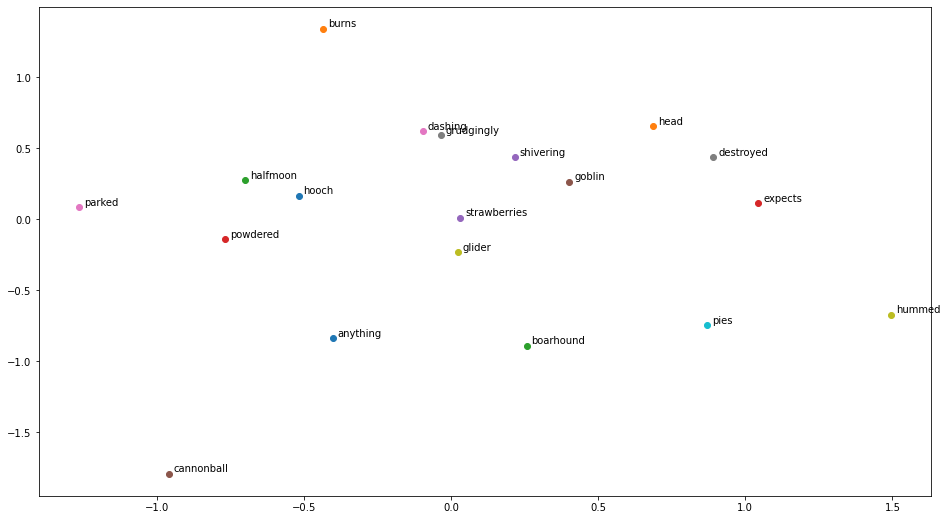

In [50]:
plt.figure(figsize=(16, 9))
for i, word in enumerate(vocabs[1:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Word2Vec (Skipgram) With Negative Sampling

In [51]:
z = 0.001

In [52]:
#count
from collections import Counter

word_count = Counter(flatten(tokenized_corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

42448

In [53]:
vocabs

['africa',
 'anything',
 'head',
 'halfmoon',
 'expects',
 'shivering',
 'goblin',
 'parked',
 'destroyed',
 'glider',
 'pies',
 'hooch',
 'burns',
 'boarhound',
 'powdered',
 'strawberries',
 'cannonball',
 'dashing',
 'grudgingly',
 'hummed',
 'sleep',
 'terrified',
 'dusty',
 'stiffly',
 'brew',
 'earn',
 'vanished',
 'work',
 'pinkfaced',
 'breakin',
 'watch',
 'basket',
 'monk',
 'boxes',
 'lasted',
 'shiny',
 'towering',
 'reared',
 'halfway',
 'cows',
 'haircut',
 'judging',
 'innocent',
 'smaller',
 'finally',
 'best',
 'pewter',
 'november',
 'mumbled',
 'jars',
 'mixture',
 'speechless',
 'sneak',
 'wafting',
 'froze',
 'trained',
 'sets',
 'candies',
 'nonsense',
 'weave',
 'panic',
 'moaned',
 'creeps',
 'tricks',
 'angelina',
 'horror',
 'albus',
 'leaned',
 'coat',
 'mounted',
 'jokes',
 'reckon',
 'meself',
 'smiling',
 'hung',
 'monkshood',
 'changing',
 'threes',
 'diversion',
 'standing',
 'chessboard',
 'part',
 'blankets',
 'smelled',
 'hengist',
 'affect',
 'fainte

In [54]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)

Counter(unigram_table)

Counter({'anything': 8,
         'head': 10,
         'goblin': 1,
         'hooch': 2,
         'sleep': 2,
         'terrified': 1,
         'vanished': 1,
         'work': 4,
         'watch': 2,
         'towering': 1,
         'halfway': 1,
         'finally': 3,
         'best': 4,
         'mumbled': 1,
         'panic': 1,
         'moaned': 1,
         'horror': 1,
         'albus': 2,
         'leaned': 2,
         'coat': 2,
         'reckon': 1,
         'smiling': 3,
         'hung': 2,
         'standing': 4,
         'blankets': 1,
         'lights': 1,
         'cart': 2,
         'boy': 9,
         'pile': 2,
         'leaky': 1,
         'nervously': 2,
         'lock': 1,
         'golden': 1,
         'gang': 1,
         'agreed': 1,
         'kept': 5,
         'dragons': 3,
         'shook': 2,
         'frightened': 1,
         'leapt': 2,
         'idea': 3,
         'everything': 4,
         'proper': 1,
         'number': 2,
         'clutching': 1,
         '

In [55]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [56]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))

    return torch.cat(neg_samples) #batch_size, k

In [57]:
batch_size = 2
x, y = random_batch(batch_size, tokenized_corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [58]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [59]:
y_tensor[1]

tensor([4343])

In [60]:
neg_samples[1]

tensor([1753, 3550, 2457, 2147, 1585])

In [61]:
class SkipgramNeg(nn.Module):

    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()

    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)

        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)

        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)

        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)

        return -torch.mean(loss)

In [62]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model_2 = SkipgramNeg(voc_size, emb_size)

In [63]:
loss = model_2(x_tensor, y_tensor, neg_samples)

In [64]:
loss

tensor(0.7750, grad_fn=<NegBackward0>)

In [65]:
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [66]:
import time
time_start = time.time()
num_epochs = 10000

for epoch in range(num_epochs):

    #get batch
    input_batch, label_batch = random_batch(batch_size, tokenized_corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)

    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model_2(input_tensor, label_tensor, neg_samples)

    #backprogate
    optimizer.zero_grad()
    loss.backward()

    #update alpha
    optimizer.step()

    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")
end_time = time.time()
total_neg_sampling_training_time = end_time - time_start
print(total_neg_sampling_training_time)

sg_with_sampling_result = {"model_name":"Skipgram with negative sampling", "window_size":window_size,  "training_loss": f"{loss:2.6f}", "training_time":total_neg_sampling_training_time/60}

Epoch   1000 | Loss: 1.873864
Epoch   2000 | Loss: 0.362454
Epoch   3000 | Loss: 0.687557
Epoch   4000 | Loss: 1.163476
Epoch   5000 | Loss: 2.850953
Epoch   6000 | Loss: 1.267166
Epoch   7000 | Loss: 1.652139
Epoch   8000 | Loss: 1.567004
Epoch   9000 | Loss: 1.035234
Epoch  10000 | Loss: 1.652158
1484.8456914424896


In [67]:
sg_with_sampling_result

{'model_name': 'Skipgram with negative sampling',
 'window_size': 2,
 'training_loss': '1.652158',
 'training_time': 24.74742819070816}

### GLOVE

In [68]:
#Build Co-occurence Matrix X
from collections import Counter

X_i = Counter(flatten(tokenized_corpus))
X_i

Counter({'boy': 83,
         'lived': 9,
         'mr': 81,
         'mrs': 46,
         'dursley': 54,
         'number': 17,
         'four': 31,
         'privet': 16,
         'drive': 20,
         'proud': 7,
         'say': 75,
         'perfectly': 5,
         'normal': 10,
         'thank': 8,
         'much': 76,
         'last': 82,
         'people': 92,
         'youd': 22,
         'expect': 13,
         'involved': 5,
         'anything': 74,
         'strange': 22,
         'mysterious': 6,
         'didnt': 195,
         'hold': 12,
         'nonsense': 4,
         'director': 2,
         'firm': 2,
         'called': 44,
         'grunnings': 2,
         'made': 66,
         'drills': 6,
         'big': 28,
         'beefy': 1,
         'man': 33,
         'hardly': 22,
         'neck': 18,
         'although': 11,
         'large': 51,
         'mustache': 6,
         'thin': 10,
         'blonde': 2,
         'nearly': 37,
         'twice': 15,
         'usual': 18,


In [69]:
skip_grams = []

for doc in tokenized_corpus:
    for i in range(window_size, len(doc)-window_size):
        center = doc[i]
        outside = [doc[i-2], doc[i-1], doc[i+1], doc[i+2]]
        for each_out in outside:
            skip_grams.append((center, each_out))
skip_grams

[('mr', 'boy'),
 ('mr', 'lived'),
 ('mr', 'mrs'),
 ('mr', 'dursley'),
 ('mrs', 'lived'),
 ('mrs', 'mr'),
 ('mrs', 'dursley'),
 ('mrs', 'number'),
 ('dursley', 'mr'),
 ('dursley', 'mrs'),
 ('dursley', 'number'),
 ('dursley', 'four'),
 ('number', 'mrs'),
 ('number', 'dursley'),
 ('number', 'four'),
 ('number', 'privet'),
 ('four', 'dursley'),
 ('four', 'number'),
 ('four', 'privet'),
 ('four', 'drive'),
 ('privet', 'number'),
 ('privet', 'four'),
 ('privet', 'drive'),
 ('privet', 'proud'),
 ('drive', 'four'),
 ('drive', 'privet'),
 ('drive', 'proud'),
 ('drive', 'say'),
 ('proud', 'privet'),
 ('proud', 'drive'),
 ('proud', 'say'),
 ('proud', 'perfectly'),
 ('say', 'drive'),
 ('say', 'proud'),
 ('say', 'perfectly'),
 ('say', 'normal'),
 ('perfectly', 'proud'),
 ('perfectly', 'say'),
 ('perfectly', 'normal'),
 ('perfectly', 'thank'),
 ('normal', 'say'),
 ('normal', 'perfectly'),
 ('normal', 'thank'),
 ('normal', 'much'),
 ('youd', 'last'),
 ('youd', 'people'),
 ('youd', 'expect'),
 ('youd'

In [70]:
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('mr', 'boy'): 1,
         ('mr', 'lived'): 1,
         ('mr', 'mrs'): 2,
         ('mr', 'dursley'): 14,
         ('mrs', 'lived'): 1,
         ('mrs', 'mr'): 2,
         ('mrs', 'dursley'): 10,
         ('mrs', 'number'): 1,
         ('dursley', 'mr'): 15,
         ('dursley', 'mrs'): 10,
         ('dursley', 'number'): 1,
         ('dursley', 'four'): 1,
         ('number', 'mrs'): 1,
         ('number', 'dursley'): 1,
         ('number', 'four'): 5,
         ('number', 'privet'): 1,
         ('four', 'dursley'): 1,
         ('four', 'number'): 4,
         ('four', 'privet'): 1,
         ('four', 'drive'): 1,
         ('privet', 'number'): 1,
         ('privet', 'four'): 1,
         ('privet', 'drive'): 13,
         ('privet', 'proud'): 1,
         ('drive', 'four'): 1,
         ('drive', 'privet'): 11,
         ('drive', 'proud'): 1,
         ('drive', 'say'): 1,
         ('proud', 'privet'): 1,
         ('proud', 'drive'): 1,
         ('proud', 'say'): 1,
         ('proud

In [71]:
def weighting(w_i, w_j, X_ik):

    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1

    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75

    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1

    return result

In [72]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass

    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

In [73]:
# Prepare Training
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):

    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []

    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]

    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)

    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])

        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])

    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [74]:
#Testing
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, tokenized_corpus, skip_grams, X_ik, weighting_dic)

In [75]:
x

array([[5523],
       [1277]])

In [76]:
y

array([[5587],
       [3568]])

In [77]:
cooc

array([[0.69314718],
       [0.69314718]])

In [78]:
weighting

array([[0.05318296],
       [0.05318296]])

In [79]:
class Glove(nn.Module):

    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

        self.center_bias       = nn.Embedding(voc_size, 1)
        self.outside_bias      = nn.Embedding(voc_size, 1)

    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.embedding_center(center) #(batch_size, 1, emb_size)
        outside_embeds = self.embedding_outside(outside) #(batch_size, 1, emb_size)

        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)

        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)

        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)

        return torch.sum(loss)

In [80]:
#test our system
voc_size = len(vocabs)
emb_size = 2
model_3 = Glove(voc_size, emb_size)

In [81]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [82]:
loss = model_3(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [83]:
loss

tensor(0.1127, grad_fn=<SumBackward0>)

In [84]:
#Training
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model_3          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

In [85]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [86]:

start_time  = time.time()

# Training
num_epochs = 10000
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model_3(input_batch, target_batch, cooc_batch, weighting_batch)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

end_time = time.time()

total_glove_training_time = end_time - start_time

glove_result = {"model_name":"Glove", "window_size":window_size,  "training_loss": loss, "training_time":total_glove_training_time}



Epoch: 1000 | cost: 4.184255 | time: 0m 0s
Epoch: 2000 | cost: 1.544418 | time: 0m 0s
Epoch: 3000 | cost: 14.463698 | time: 0m 0s
Epoch: 4000 | cost: 1.330217 | time: 0m 0s
Epoch: 5000 | cost: 1.549320 | time: 0m 0s
Epoch: 6000 | cost: 0.214742 | time: 0m 0s
Epoch: 7000 | cost: 2.071505 | time: 0m 0s
Epoch: 8000 | cost: 1.077177 | time: 0m 0s
Epoch: 9000 | cost: 0.483016 | time: 0m 0s
Epoch: 10000 | cost: 1.210199 | time: 0m 0s


In [87]:
glove_result

{'model_name': 'Glove',
 'window_size': 2,
 'training_loss': tensor(1.2102, grad_fn=<SumBackward0>),
 'training_time': 460.72538208961487}

# Task 2

### 2.1

In [92]:
import pandas as pd
result_list = [sg_without_sampling_result, sg_with_sampling_result, glove_result]
result_df = pd.DataFrame.from_dict(result_list)
result_df.head()

,model_name,window_size,training_loss,training_time
0,Skipgram Without Negative Sampling,2,8.686974,25.110363
1,Skipgram with negative sampling,2,1.652158,24.747428
2,Glove,2,"tensor(1.2102, grad_fn=<SumBackward0>)",460.725382


### 2.2

In [93]:
# Get word embeddings give trained word2vec or glove model for a given word

def get_embeddings(word, model):  
        word = torch.LongTensor([word2index[word]])
        
        embed_c = model.embedding_center(word)
        embed_o = model.embedding_outside(word)
        word_embed   = (embed_c + embed_o) / 2
        x, y = word_embed[0][0].item(), word_embed[0][1].item()
        return x,y

In [96]:
get_embeddings('potter', model_1)

(0.05945122241973877, -0.0027467012405395508)

In [97]:
#  Calculate the cosine similarity between two vectors.

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0  # To handle the case when one of the vectors is a zero vector
    
    return dot_product / (norm_vec1 * norm_vec2)


In [98]:
vocabs[1]

'anything'

In [103]:
import numpy as np

#  Find the most similar word to complete the analogy: a is to b as c is to ? using cosine similarity.
def get_most_similar_words(a, b, c, model, topn=1):
    try:
        vector_a = get_embeddings(a, model)
        vector_b = get_embeddings(b, model)
        vector_c = get_embeddings(c, model)
    except KeyError:
    #     # Handle the case when any of the words is not in the vocabulary
        return None

    # Calculate the expected vector
    expected_vector = np.array(vector_b) - np.array(vector_a) + np.array(vector_c)

    # Calculate cosine similarity between the expected vector and all other vectors in the model
    similarities = [(w, np.dot(expected_vector, np.array(get_embeddings(w, model))) / (np.linalg.norm(expected_vector) * np.linalg.norm(np.array(get_embeddings(w, model)))))
                     for w in vocabs if w not in {a, b, c}]

    # Sort by similarity and get the top predicted word(s)
    similarities.sort(key=lambda x: x[1], reverse=True)
    predicted_words = [word for word, _ in similarities[:topn]]

    return predicted_words


In [104]:
# Calculate semantic accuracy on the given analogy dataset for the trained model.



def calculate_semantic_syntactic_accuracy(analogy_file, model):
    correct = 0
    total = 0

    with open(analogy_file, 'r') as file:
        for line in file:
            if line.startswith(':'):
                # Skip lines starting with ':' as they contain category labels
                continue

            words = line.strip().lower().split()

            if len(words) != 4:
                # Skip lines that do not have exactly four words
                continue

            # Extract the analogy components
            a, b, c, expected = words

            try:
                # Calculate the analogy and check if the predicted word matches the expected word
                predicted = get_most_similar_words(b, c, a, model, topn=1)[0][0]
                if predicted == expected:
                    correct += 1
            except:
                # Handle the case when one of the words is not in the vocabulary
                continue

            total += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy




In [105]:
semantic_analogy_file_path = 'word-analogies-datasets/capital-countries.txt'

skipgram_semantic_accuracy = calculate_semantic_syntactic_accuracy(semantic_analogy_file_path, model_1)
skipgram_neg_semantic_accuracy =  calculate_semantic_syntactic_accuracy(semantic_analogy_file_path, model_2)
glove_semantic_accuracy = calculate_semantic_syntactic_accuracy(semantic_analogy_file_path, model_3)

In [106]:
print(f'Semantic Accuracy (Skipgram without neg sampling): {skipgram_semantic_accuracy * 100:.2f}%')
print(f'Semantic Accuracy (Skipgram with neg sampling): {skipgram_neg_semantic_accuracy * 100:.2f}%')
print(f'Semantic Accuracy (Glove): {glove_semantic_accuracy * 100:.2f}%')

Semantic Accuracy (Skipgram without neg sampling): 0.00%
Semantic Accuracy (Skipgram with neg sampling): 0.00%
Semantic Accuracy (Glove): 0.00%


In [ ]:
sg_without_sampling_result['semantic_accuracy'] = skipgram_semantic_accuracy
sg_with_sampling_result['semantic_accuracy'] = skipgram_neg_semantic_accuracy
glove_result['semantic_accuracy'] = glove_semantic_accuracy

In [107]:
syntactic_analogy_file_path = 'word-analogies-datasets/past-tense.txt'

skipgram_syntactic_accuracy = calculate_semantic_syntactic_accuracy(syntactic_analogy_file_path, model_1)
skipgram_neg_syntactic_accuracy =  calculate_semantic_syntactic_accuracy(syntactic_analogy_file_path, model_2)
glove_syntactic_accuracy = calculate_semantic_syntactic_accuracy(syntactic_analogy_file_path, model_3)

In [ ]:
print(f'Syntatic Accuracy (Skipgram without neg sampling): {skipgram_syntatic_accuracy * 100:.2f}%')
print(f'Syntatic Accuracy (Skipgram with neg sampling): {skipgram_neg_syntatic_accuracy * 100:.2f}%')
print(f'Syntatic Accuracy (Glove): {glove_syntatic_accuracy * 100:.2f}%')

In [ ]:
sg_without_sampling_result['syntactic_accuracy'] = skipgram_semantic_accuracy
sg_with_sampling_result['syntactic_accuracy'] = skipgram_neg_semantic_accuracy
glove_result['syntactic_accuracy'] = glove_semantic_accuracy